In [ ]:
%pip install matplotlib pyyaml

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from src.model import SASModel
from src.dataset import SASDataset
from torch.utils.data import DataLoader
from src.util import CFG

In [152]:
cfg = CFG('config.yaml')
tier = 'diamond'
match_df = pd.read_csv(os.path.join(cfg['data_dir'], f'{tier}_match_by_match_mod.csv'), compression='gzip')
summoner_df = pd.read_csv(os.path.join(cfg['data_dir'], f'{tier}_match_by_summoner_mod.csv'), compression='gzip')

# cfg['n_layers'] = match_df[cfg['cate_cols']].max().max() + 1

cfg["batch_size"] = 128
cfg['emb_size'] = 32
cfg['hidden_size'] = 256
cfg['n_layers'] = 1866

# 예제 모델과 데이터셋
dataset = SASDataset(cfg, summoner_df, match_df)
data_loader = DataLoader(dataset=dataset, batch_size=cfg["batch_size"])


In [153]:
loaded = torch.load(f=os.path.join(cfg['model_dir'], f"5.10%_2024_03_18_17_02.pt"))


model = SASModel(cfg)  # 여기서 YourModel은 사전에 정의된 유사도 모델입니다.

state_dict = loaded['model']
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [250]:
num_of_label = 16

In [251]:
# 모델의 임베딩 추출하기
embedding_m = []
labels = []
start = 0
num_of_emb = num_of_label * 10

model.eval()
with torch.no_grad():
    for cate, cont, pos in data_loader:
        embedding = model(cate, cont, pos)  # 모델을 통해 임베딩 생성
        embedding_m.append(embedding.view(embedding.size(0) * embedding.size(1), embedding.size(2)).numpy())  # CPU로 이동 후 numpy 배열로 변환

        # print(len(embedding_m[0]))
        for i in range(start, start + embedding.size(0)):
            # labels.append(np.array([i] * 10 * 128))
            labels.append(np.array([i] * 10))
        start += embedding.size(0)

        if len(embedding_m[0]) >= num_of_label * 10:
            embedding_m[0] = embedding_m[0][:num_of_label * 10]
            labels = labels[:num_of_label]
            # print(embedding_m.shape)
            # print(labels.shape)
            break

        # break


In [252]:
embedding_m = np.concatenate(embedding_m, axis=0)
labels = np.concatenate(labels, axis=0)


In [253]:
embedding_m.shape

(160, 256)

In [254]:
labels.shape

(160,)

In [255]:

# 차원 축소 (t-SNE 또는 PCA 사용)
tsne = TSNE(n_components=2, perplexity=num_of_label, random_state=0)
embeddings_2d = tsne.fit_transform(embedding_m)  # t-SNE 사용


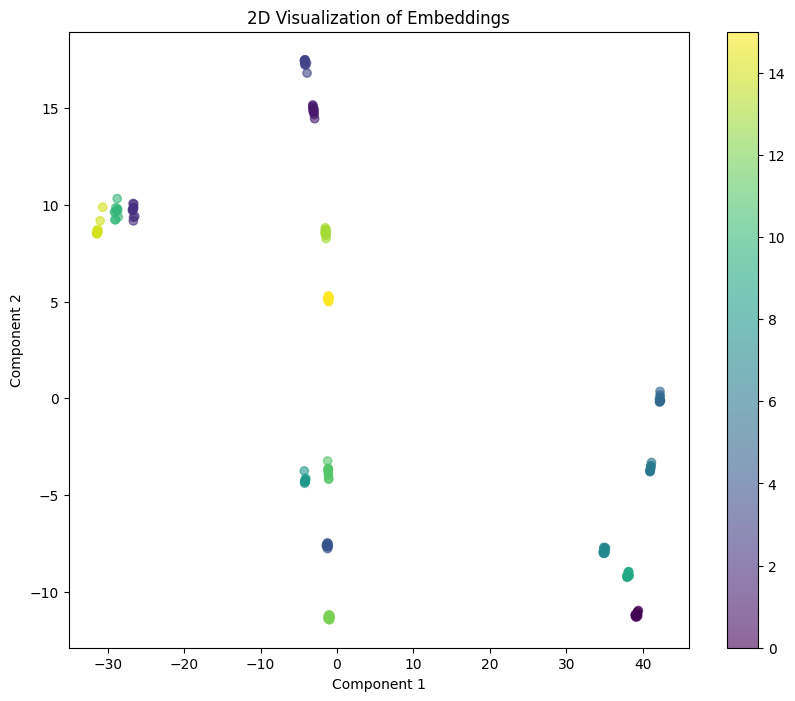

In [256]:

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
# for label in np.unique(labels):
#     indices = labels == label
#     plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, alpha=0.6)

# plt.legend()
plt.colorbar(scatter)
plt.title('2D Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()